In [27]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

import random


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

/tmp/ipykernel_10281/3361398283.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [29]:
train_transform = transforms.Compose(
    [transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(root ="data/", transform=train_transform)

train_loader = data.DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True)

def get_train_images(num):
    return torch.stack([dataset[random.randint(0, 20000)][0] for i in range(10,10+num)], dim=0)

In [5]:
dataset.samples

[('data/00000/00000_00000/00000_00000.jpg', 0),
 ('data/00000/00000_00001/00000_00001.jpg', 0),
 ('data/00000/00000_00002/00000_00002.jpg', 0),
 ('data/00000/00000_00003/00000_00003.jpg', 0),
 ('data/00000/00000_00004/00000_00004.jpg', 0),
 ('data/00000/00000_00005/00000_00005.jpg', 0),
 ('data/00000/00000_00006/00000_00006.jpg', 0),
 ('data/00000/00000_00007/00000_00007.jpg', 0),
 ('data/00000/00000_00008/00000_00008.jpg', 0),
 ('data/00000/00000_00009/00000_00009.jpg', 0),
 ('data/00000/00000_00010/00000_00010.jpg', 0),
 ('data/00000/00000_00011/00000_00011.jpg', 0),
 ('data/00000/00000_00012/00000_00012.jpg', 0),
 ('data/00000/00000_00013/00000_00013.jpg', 0),
 ('data/00000/00000_00014/00000_00014.jpg', 0),
 ('data/00000/00000_00015/00000_00015.jpg', 0),
 ('data/00000/00000_00016/00000_00016.jpg', 0),
 ('data/00000/00000_00017/00000_00017.jpg', 0),
 ('data/00000/00000_00018/00000_00018.jpg', 0),
 ('data/00000/00000_00019/00000_00019.jpg', 0),
 ('data/00000/00000_00020/00000_00020.jp

In [22]:
get_train_images(1).shape

torch.Size([1, 3, 32, 32])

In [103]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=8, normalize=False)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [31]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [195]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

# VAE

In [179]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.fc_1 = nn.Linear(128*8*8, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x) )
        x = F.leaky_relu(self.conv3(x) )
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 128*8*8)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 128, 8, 8])
        x_hat = F.leaky_relu(self.conv2(x_hat) )
        x_hat = F.leaky_relu(self.conv3(x_hat) )
        return x_hat

In [180]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        # Change to proper sampling
        z = mean
        z = torch.randn_like(mean) * var + mean
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [183]:
vae = VAE(latent_dim=512, hidden_dim=1028, x_dim=3072).to(device)
vae

VAE(
  (encoder): Encoder(
    (conv2): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_1): Linear(in_features=8192, out_features=1028, bias=True)
    (fc_2): Linear(in_features=1028, out_features=1028, bias=True)
    (fc_mean): Linear(in_features=1028, out_features=512, bias=True)
    (fc_var): Linear(in_features=1028, out_features=512, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (fc_1): Linear(in_features=512, out_features=1028, bias=True)
    (fc_2): Linear(in_features=1028, out_features=1028, bias=True)
    (fc_3): Linear(in_features=1028, out_features=8192, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [184]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # regularyzacja

    return reproduction_loss + KLD

In [185]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [186]:
num_epochs = 10
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(train_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 37072.10951542075, test L1 = 0.1263542317487056
Epoch 1 loss 27609.75469771242, test L1 = 0.1230002011543785
Epoch 2 loss 24940.3686938317, test L1 = 0.11081911453039818
Epoch 3 loss 21341.849979575163, test L1 = 0.10177507670291888
Epoch 4 loss 19433.107664419935, test L1 = 0.0967146954407879
Epoch 5 loss 18215.71467141544, test L1 = 0.09347355341404871
Epoch 6 loss 17502.244249131945, test L1 = 0.0906508184628549
Epoch 7 loss 16920.463318270016, test L1 = 0.08799713290010402
Epoch 8 loss 16410.68753191381, test L1 = 0.08622258701939987
Epoch 9 loss 15919.216094771242, test L1 = 0.08529445421851538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


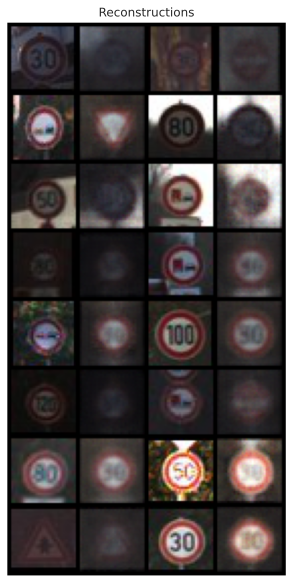

In [187]:
input_imgs = get_train_images(16)
visualize_reconstructions(vae, input_imgs, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


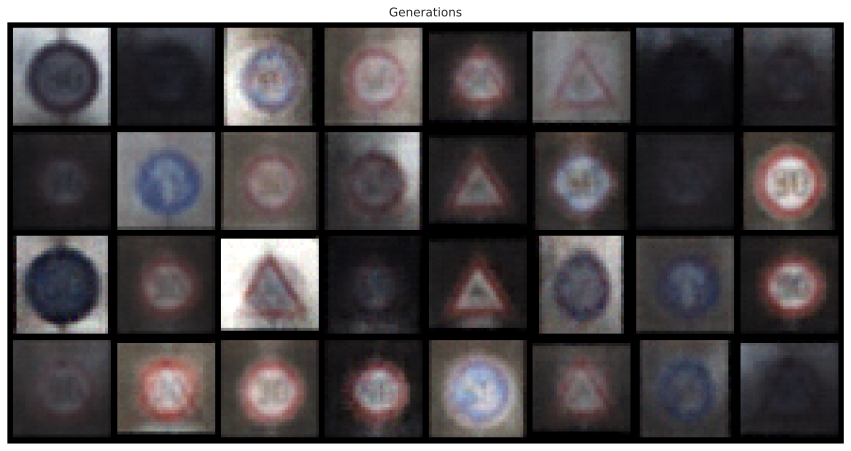

In [189]:
generate_images(vae, 32 , device)

In [191]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))

In [192]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [193]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
# test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

/tmp/ipykernel_10281/1789624700.py:11: UserWarning: 
The palette list has fewer values (10) than needed (43) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


TypeError: Invalid shape (3, 32, 32) for image data

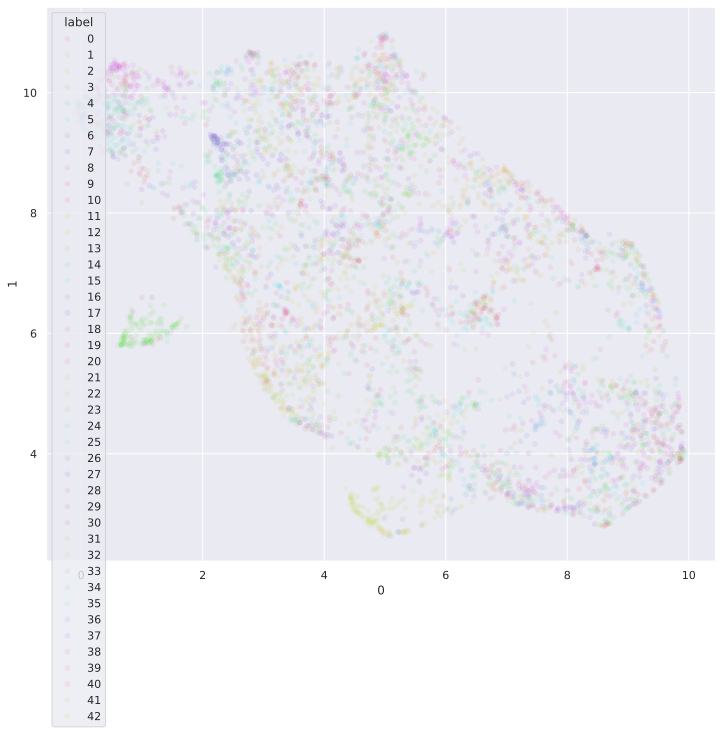

In [196]:
plot_latent(train_embedded, train_img_embeds)

# GAN

# GLOW

# VAEGAN

https://github.com/lucabergamini/VAEGAN-PYTORCH